### MLP 1 layer

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class OneLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(OneLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc1(x)

In [43]:
import time 
import numpy as np
from numpy import linalg as LA

import os, sys
from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))

from optim.sgd_sngl import OneStepSGD
from optim.sgd_mult import ManyStepSGD
from optim.fista_wo_prox import FISTA as SFISTA
from optim.fista_multi_wo_prox import FISTA as MFISTA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def modeling(X, y, p, n_step=2, lr=0.01, method='sgd', N_epochs=30):
    model = OneLayerNN(p, 1)
    criterion = nn.MSELoss()

    if n_step == 1 and method=='sgd':
        print("Using OneStepSGD")
        optimizer = OneStepSGD(model.parameters(), lr=lr)
    elif n_step >1 and method=='sgd':
        print("Using ManyStepSGD")
        optimizer = ManyStepSGD(model.parameters(), lr=lr, n_step=n_step)
    elif n_step == 1 and method=='fista':
        print("Using single FISTA")
        optimizer = SFISTA(model.parameters(), lr=lr)
    elif n_step > 1 and method=='fista':
        print("Using FISTA with mini-steps")
        optimizer = MFISTA(model.parameters(), lr=lr, ministeps = n_step)

    train_losses = []

    def closure():
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        return loss
    
    for _ in range(N_epochs):
        model.train() 
        optimizer.zero_grad()
        if n_step == 1:
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        else:
            loss = optimizer.step(closure)
        train_losses.append(loss.item())

    return train_losses


### Find optimal step size in case Overdetermined

Using OneStepSGD
Using OneStepSGD
Using OneStepSGD
Using OneStepSGD
Using OneStepSGD
Using OneStepSGD


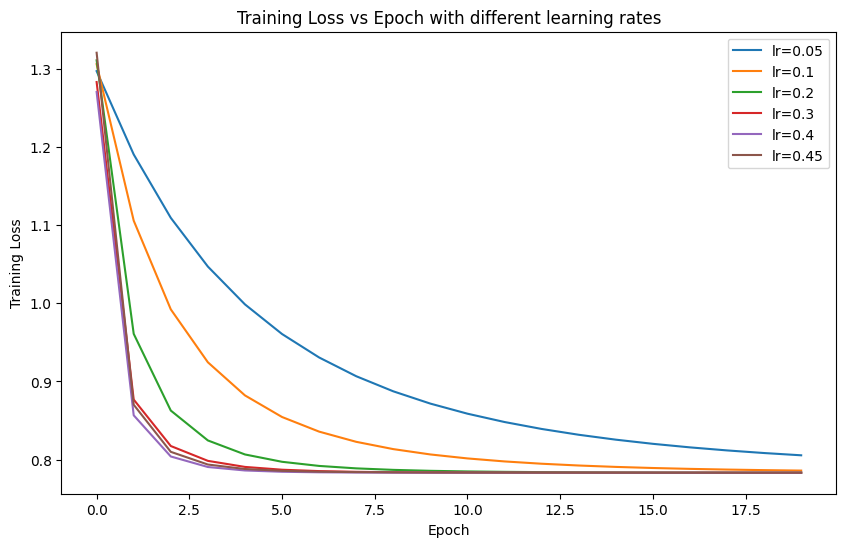

In [ ]:
n, p = 5000, 1000
X = torch.tensor(np.random.randn(n, p), dtype=torch.float32)
y = torch.tensor(np.random.randn(n, 1), dtype=torch.float32)

_lr = 1/(LA.norm(X.cpu().detach().numpy()))**2

N_epochs = 20
train_losses = {}
for lr  in [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]:
    _losses = modeling(X, y, p, n_step=1, lr=lr, method='sgd', N_epochs=N_epochs)
    train_losses[lr] = _losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, losses in train_losses.items():
    plt.plot(losses, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch with different learning rates')
plt.legend()
plt.show()

In [70]:
import numpy as np

n, p = 5000, 1000
x = np.random.randn(n, p)   # shape = (5000, 1000)
y = np.random.randn(n, 1)   # shape = (5000, 1)

w, *_ = np.linalg.lstsq(x, y, rcond=None)
w.shape


(1000, 1)

Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps


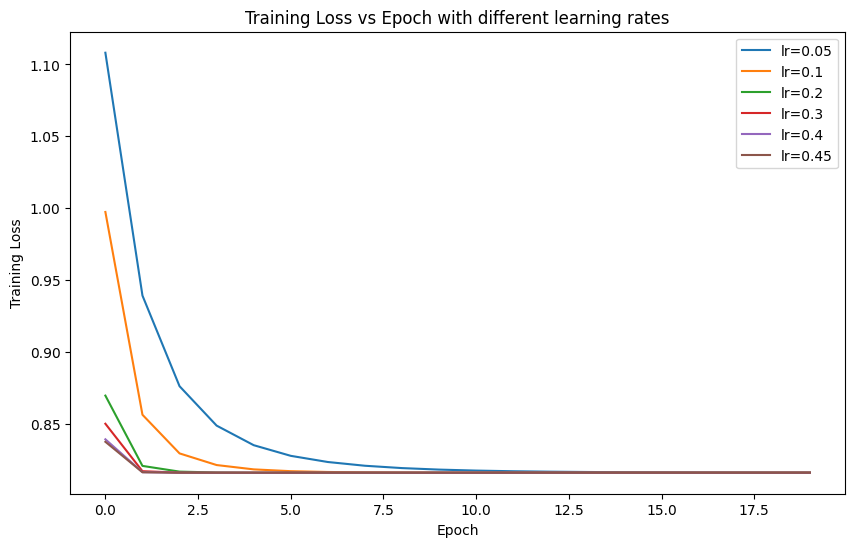

In [ ]:
n, p = 5000, 1000
X = torch.tensor(np.random.randn(n, p), dtype=torch.float32)
y = torch.tensor(np.random.randn(n, 1), dtype=torch.float32)

_lr = 1/(np.linalg.norm(X.cpu().detach().numpy()))**2


N_epochs = 20
train_losses = {}
for lr  in [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]:
    _losses = modeling(X, y, p, n_step=3, lr=lr, method='fista', N_epochs=N_epochs)
    train_losses[lr] = _losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, losses in train_losses.items():
    plt.plot(losses, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch with different learning rates')
plt.legend()
plt.show()

### Overdetermined $n > q$

Using OneStepSGD
Using ManyStepSGD
Using single FISTA
Using FISTA with mini-steps


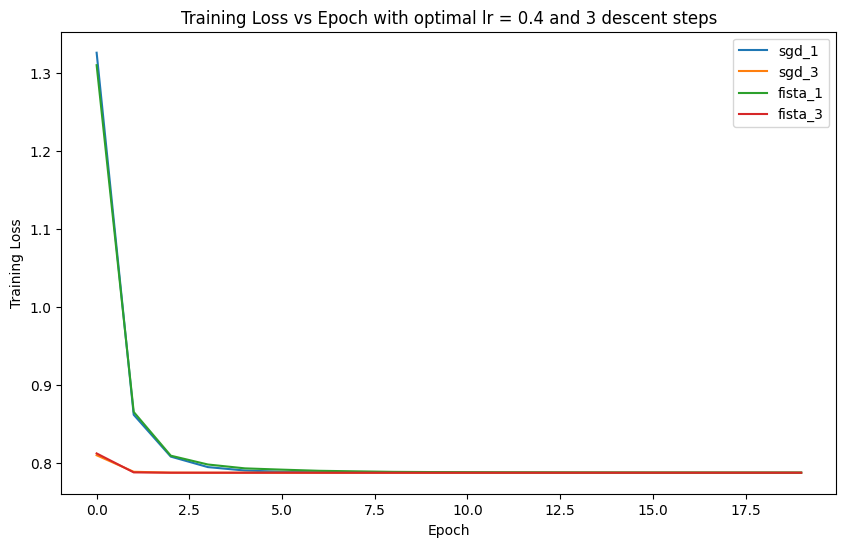

In [ ]:
n, p = 5000, 1000
X = torch.tensor(np.random.randn(n, p), dtype=torch.float32)
y = torch.tensor(np.random.randn(n, 1), dtype=torch.float32)

_lr = 1/(np.linalg.norm(X.cpu().detach().numpy()))**2

N_epochs = 20
train_losses = {}
lr = .4
for method in ['sgd', 'fista']:
    for step  in [1, 3]:
        _losses = modeling(X, y, p, n_step=step, lr=lr, method=method, N_epochs=N_epochs)
        train_losses[f"{method}_{step}"] = _losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for key, losses in train_losses.items():
    plt.plot(losses, label=f'{key}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch with optimal lr = 0.4 and 3 descent steps')
plt.legend()
plt.show()

### Underdetermined $n < q$

#### Find optimal learning rate

Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps
Using FISTA with mini-steps


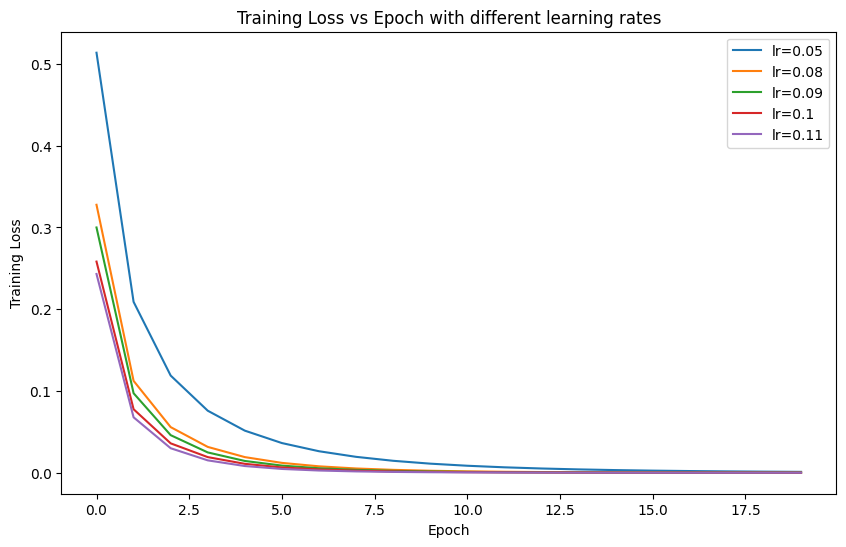

In [ ]:
n, p = 1000, 2000
X = torch.tensor(np.random.randn(n, p), dtype=torch.float32)
y = torch.tensor(np.random.randn(n, 1), dtype=torch.float32)

_lr = 1/(np.linalg.norm(X.cpu().detach().numpy(), 2))**2

N_epochs = 20
train_losses = {}
for lr  in [0.05, 0.08, 0.09, 0.1, 0.11]:
    _losses = modeling(X, y, p, n_step=3, lr=lr, method='fista', N_epochs=N_epochs)
    train_losses[lr] = _losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, losses in train_losses.items():
    plt.plot(losses, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch with different learning rates')
plt.legend()
plt.show()

2.89136047097421e-05
Using OneStepSGD
Using ManyStepSGD
Using single FISTA
Using FISTA with mini-steps


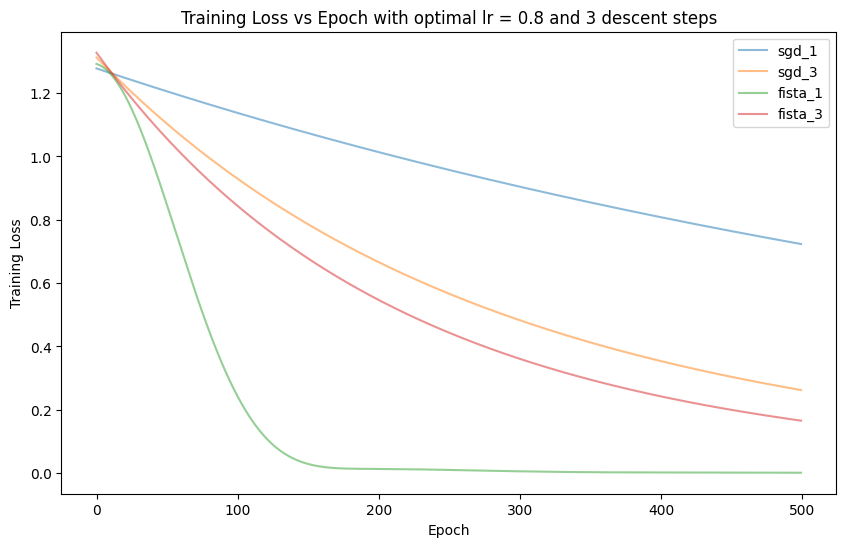

In [ ]:
n, p = 2000, 20000
X = torch.tensor(np.random.randn(n, p), dtype=torch.float32)
y = torch.tensor(np.random.randn(n, 1), dtype=torch.float32)

_lr = 1/(np.linalg.norm(X.cpu().detach().numpy(), 2))**2
print(_lr)
N_epochs = 500
train_losses = {}
lr = .08
for method in ['sgd', 'fista']:
    for step  in [1, 3]:
        # if method=='sgd' and step>1:
            # continue
        _losses = modeling(X, y, p, n_step=step, lr=_lr, method=method, N_epochs=N_epochs)
        train_losses[f"{method}_{step}"] = _losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for key, losses in train_losses.items():
    plt.plot(losses, label=f'{key}', alpha=.5)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch with optimal lr = 0.8 and 3 descent steps')
plt.legend()
plt.show()

### Back Up

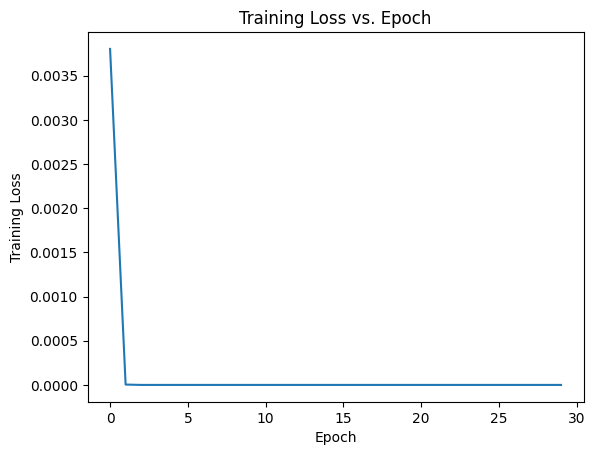

In [53]:
import os, sys
from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))
from optim.fista_multi_wo_prox import FISTA

n, p = 1000, 5000

X = torch.randn(n, p)
Y = torch.randn(n, 1)

model = OneLayerNN(input_size=p, output_size=1)
criterion = nn.MSELoss()

opt_method = "FISTA"
if opt_method == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.4)
elif opt_method == "FISTA":
    optimizer = FISTA(model.parameters(), lr=0.1)

# Train
N_epochs = 30
train_losses = []

# Closure
def closure():
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    return loss

for epoch in range(N_epochs):
    model.train()
    if opt_method == "FISTA":
        loss = optimizer.step(closure)
    elif opt_method == "SGD":
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epoch")
plt.show()